In [224]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# whats the difference betwen scalers? 

In [194]:
df = pd.read_csv('/Users/sammarcustaylor/Desktop/kc_final.csv')
df.drop(columns = ['Unnamed: 0', 'id', 'date', 'sqft_living15', 'sqft_lot15', 'lat', 'long', 'zipcode'], inplace = True)
sq_ft_sum = df['sqft_living']+ df['sqft_lot']+df['sqft_above']+df['sqft_basement']
df['sqft_total']= sq_ft_sum
df['price_per_sqft'] = df['price']/df['sqft_total']

view = df['view'].replace([2,3,4],1)
df['view'] = view

# Exploratory Data Analysis

In [7]:
# check for null values 
df.isnull().sum()

# visualize the null values example
# df[df['condition'].isnull()]

# deleting the null values
# df.dropna()



price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view              0
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
sqft_total        0
price_per_sqft    0
dtype: int64

In [8]:
for column in df:
    unique_vals = np.unique(df[column])
    num_values = len(unique_vals)
    if num_values < 10:
         print("The number of values for feature {} : {} --> {}".format(column, num_values, unique_vals))
    else:
        print("The number of values for feature {} : {}".format(column, num_values, unique_vals))
        

# This shows the distinct number of values for each feature. Quick easy way to go through all features, and see 
# important details.  

The number of values for feature price : 4028
The number of values for feature bedrooms : 13
The number of values for feature bathrooms : 30
The number of values for feature sqft_living : 1038
The number of values for feature sqft_lot : 9782
The number of values for feature floors : 6 --> [1.  1.5 2.  2.5 3.  3.5]
The number of values for feature waterfront : 2 --> [0 1]
The number of values for feature view : 2 --> [0 1]
The number of values for feature condition : 5 --> [1 2 3 4 5]
The number of values for feature grade : 12
The number of values for feature sqft_above : 946
The number of values for feature sqft_basement : 306
The number of values for feature yr_built : 116
The number of values for feature yr_renovated : 70
The number of values for feature sqft_total : 11578
The number of values for feature price_per_sqft : 21133


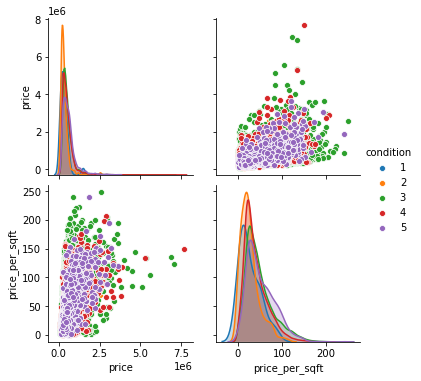

In [9]:
# visualize using SNS pairplot 

# g = sns.pairplot(df)
g = sns.pairplot(df[['price', 'price_per_sqft', 'condition']], hue = 'condition')

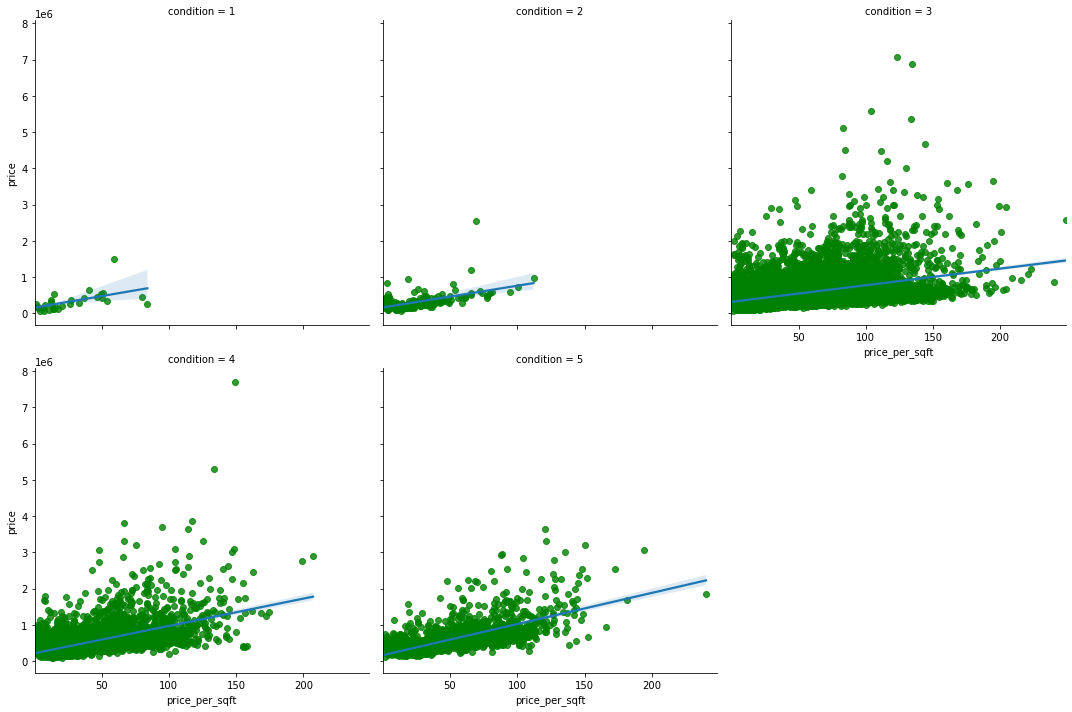

In [10]:
# examine the relationship of sq_ft living in regards to price. Segregated by grade. 

# from this graphic we can see that majority of outliers tend to fall in the condition 3, and condition 4.
# we can double check through a boxplot and see if the narrative follows. 

g = sns.lmplot(x = 'price_per_sqft' , y = 'price' , data = df, col = 'condition', col_wrap = 3, scatter_kws = {'color': 'green'})

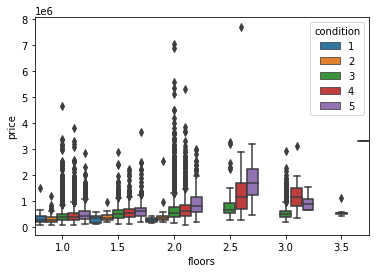

In [11]:
# investigate the distibution of housing price by a categorical variable. 
# This shows the relationship of number of floors to price, segregated by condition. 
# We can see the extreme outliers here, and them remove them. 

g = sns.boxplot(x = 'floors' , y = 'price' , data = df, hue = 'condition', width = 1, fliersize=5)

In [12]:
# filters for number below upper quartile, and deletes outliers 

def filt(num):
    df_split = df.loc[df['condition'] == num]
    thresh = df_split['price_per_sqft'].mean() + df_split['price_per_sqft'].std()
    final = df_split.loc[(df_split['price_per_sqft'] < thresh) ] 
    return(final)

one = filt(1)
two = filt(2)
three = filt(3)
four = filt(4)
five = filt(5)
df_split = pd.concat([one,two,three,four,five],ignore_index = True)

# PROVED TO BE INNEFECTIVE.. NEED TO DROP RECRODS BASED ON OUTLYING PRICE. 

# Change Categorical Variables to Numeric

In [14]:
# algorithm can not calculate strings, for example if there was a column with Monday - Friday. 
# this can be done through get dummies 

# df_split =  pd.get_dummies(df_split, columns = ['day_of_week'])

# Feature Selection

In [15]:
#select a subset of our features to feed in our algorithm. The reason for doing this is that some cases we will have 
# thousands and thousands of features. Inherently this will take too much time for ML algorithm to work. 
# The idea is to come up with a way to select important features. 

# Two ways to do this is correlation, and the feature importance from any 3 base estimators. 

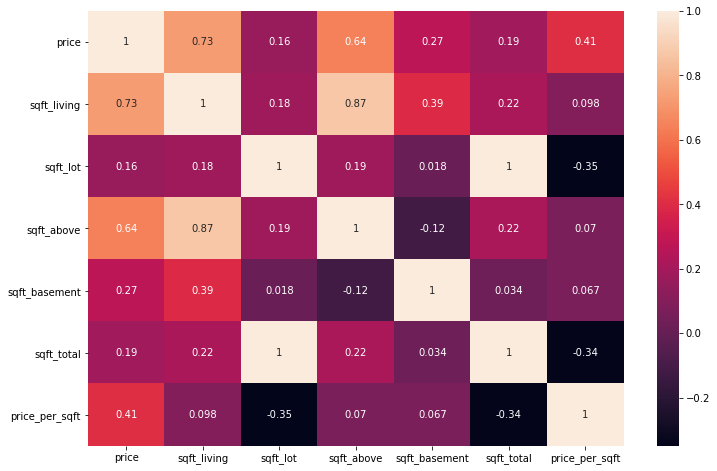

In [16]:
# running correalation. (only works on continuous features)

heatmap = df_split[['price','sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'sqft_total',
       'price_per_sqft']].corr()

# show correlation through heatmap 


fig_dims = (12,8)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(heatmap, annot= True, ax = ax)
plt.show()

In [17]:
# code to return features with high correlation. 


def correlation(dataset, threshold):
    col_corr = set()  # set all of the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:   #absolute coeff value is an option 
                colname = corr_matrix.columns[i] # getting the name of the column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df_split, 0.80)
corr_features

# Yiannis "Pick the variables that have the highest correlation with the dependent variable, and only put those
# features into the algorithm"

{'sqft_above', 'sqft_total'}

# Feature Importance

In [18]:
# Split the data into X and Y
# Run a tree based estimator [i.e decision trees and random forest]
# Run-Feature importance

# This is done in an effort to reduce entropy, and increase information gain

In [19]:
X  = df_split.drop('price', axis = 1).values
X2 = df_split.drop('price', axis = 1)
y = df_split['price']

print(X.shape)
print(y.shape)

(18295, 15)
(18295,)


In [20]:
# passing features into decision tree
# we measure based on entory as it is a measure of disorder in a dataset. 
# we want to increase information gain, in other words we want to decrease disorder by partioning on a feature in the 
# dataset. 


dt = DecisionTreeClassifier(random_state = 15, criterion = 'entropy', max_depth = 10)
dt = dt.fit(X,y)

In [ ]:
for i, column in enumerate(df_split.drop('price', axis = 1)):
    print('The feature importance for {} is {:.3f}'.format(column, dt.feature_importances_[i]))

# Analyzing Anscombe's Quartet

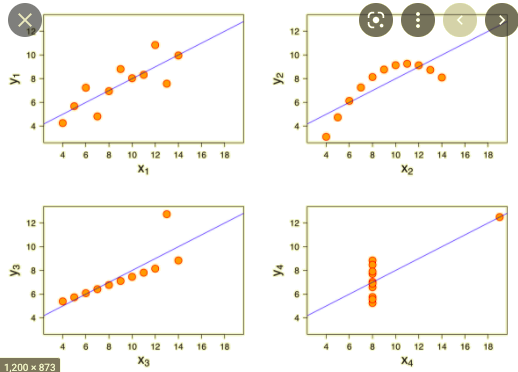

In [ ]:
#Is there a relationship in all four graphs? Best practice to visualize relationship at the start. 

# Y1"No personally. Looking at the y1 there is a relationship between X and y. As x increases y increses too"

# so linear regression is not the best choice, rather polynomial regression."

# Y3 "Linear regression performance is affected by the outlier and dragging the line upward. Therefore we should 
# remove the outler."

# Y4 " No relationship at all, outlier drags regression line from vertical to sloping."

# Running Linear Regression 

In [21]:
y = df['price'] 
X = df.drop(['price'], axis = 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [23]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_train)

## r2

In [24]:
# this is based off r2 score, and the score is better than df_split which removes outliers. 

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.79
Test set score: 0.79


# RMSE

In [25]:
# The root mean squared error is the standard deviation of the residuals. 
# RMSE is a measure of how spead out your residuals are.


# It should be noted that after removing extreme outliers the RMSE, and MAE are reduced. 

print("The RMSE on the training dataset is " , sqrt(mean_squared_error(y_train, y_pred)))

print("The RMSE on the testing dataset is " , sqrt(mean_squared_error(y_test, lr.predict(X_test))))

The RMSE on the training dataset is  166945.70290610625
The RMSE on the testing dataset is  177560.17428575366


# MAE

In [26]:
#  mean absolute error 
# the average of all absolute errors, the difference between the true value and the predicted value- then take
# the mean of all of those errors. 

# In other words on average, when predicting a house the algorithm is 109,663 dollars off. 

print("The mean absolute error on the training dataset is " , mean_absolute_error(y_train, y_pred))
print("The mean absolute error on the testing dataset is " , mean_absolute_error(y_test, lr.predict(X_test)))

The mean absolute error on the training dataset is  107103.94361214322
The mean absolute error on the testing dataset is  109663.82182419604


# Plotting Actuals vs Predicted

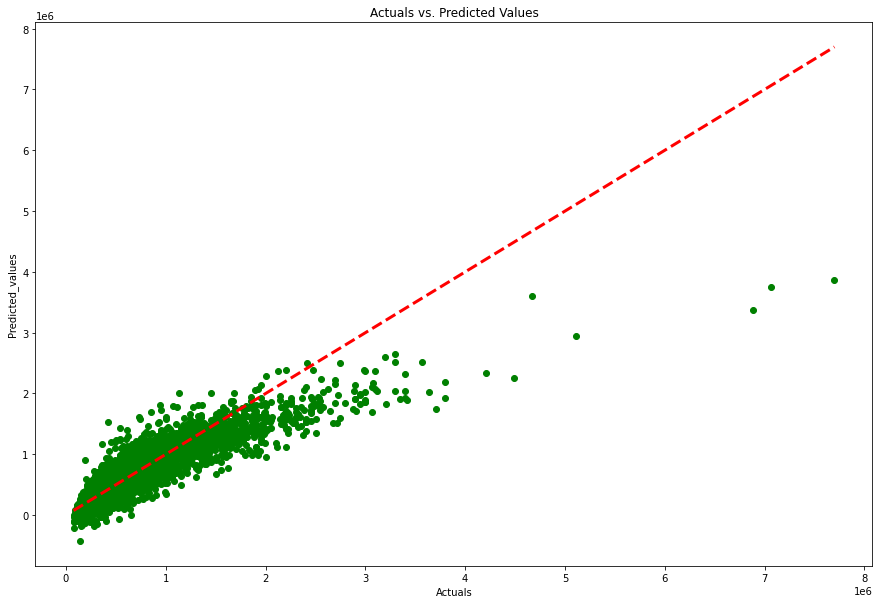

In [27]:
plt.figure(figsize = (15,10))
plt.scatter(y_train, y_pred, c = 'green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c = 'red', lw = 3)
plt.xlabel('Actuals')
plt.ylabel('Predicted_values')
plt.title('Actuals vs. Predicted Values');

# The red line is where we assume where we got all of our predicted values 100 percent correct. 
# However the outliers, for example on the right.... actual values are between 700k-800k but we are predicting 
# 3k to 4k.
# We have to do something for these datapoints. 

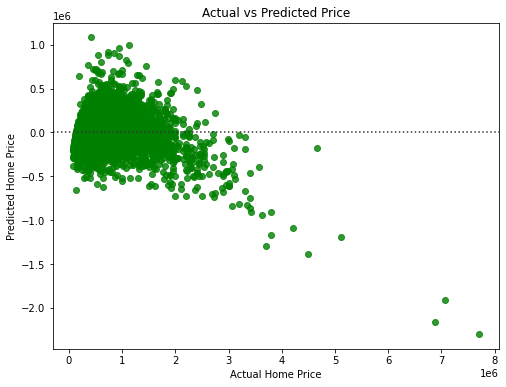

In [28]:
plt.figure(figsize = (8,6))

sns.residplot( y_train, y_pred, color = 'green')
plt.xlabel('Actual Home Price')
plt.ylabel('Predicted Home Price')
plt.title('Actual vs Predicted Price');


# The dotted black line is where we got right, the further away the more wrong the prediction was. 
# We want to see how sparse our residuals are, and see where concentration of the data points are. 

# The action here is to see if we can remove these outliers. 
# Add or remove new features. 

In [30]:
# pass coef into table
coef = lr.coef_

#reshape 
coef = coef.reshape(-1,15)

# create a dataframe
coef_df = pd.DataFrame(coef, columns = [X2.columns])
coef_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_total,price_per_sqft
0,-16658.328368,8377.622598,61.992292,-61.565435,-155622.261443,558868.325183,70456.881257,15751.563104,53652.556586,92.44828,-30.455988,-1595.167515,16.392486,62.419148,5741.657156


# LR Formula

In [31]:
# categorical variables get multiplied by zero or one. Either they exist in the formula or they do not. 
# these are the categories utilized for pd.get_dummies 


bedrooms = 3
bathrooms = 1
sqft_living = 1180 
sqft_lot = 5650
floors = 1
waterfront = 0
view = 0
condition = 3 
grade = 7
sqft_above = 1180 
sqft_basement = 0
yr_built = 1955
yr_renovated = 0
sqft_total = 8010
price_per_sqft = 27.7




pred1 = (lr.intercept_) + (coef_df['bedrooms'].values[0] * bedrooms) + (coef_df['bathrooms'].values[0] * bathrooms) + (coef_df['sqft_living'].values[0] * sqft_living) +(coef_df['sqft_lot'].values[0] * sqft_lot) +(coef_df['floors'].values[0] * floors) +(coef_df['waterfront'].values[0] * waterfront)+(coef_df['view'].values[0] * view)+(coef_df['condition'].values[0] * condition)+(coef_df['grade'].values[0] * grade)+(coef_df['sqft_above'].values[0] * sqft_above)+(coef_df['sqft_basement'].values[0] * sqft_basement)+(coef_df['yr_built'].values[0] * yr_built)+(coef_df['yr_renovated'].values[0] * yr_renovated)+(coef_df['sqft_total'].values[0] * sqft_total)+(coef_df['price_per_sqft'].values[0] * price_per_sqft)
print('The predicted house price is ' , pred1 )                 

The predicted house price is  [253386.25205637]


# Reanalyzing after Removing Outliers

In [582]:
# 95 percent of the data falls within two STDs. 

# The model performs best after removing extreme outliers. Results go down if removing too much. 
# Therefore only 12 recrods of extremties will be removed for the linear model. 

df_split = (df[df['price'] < 4000000])

print(df_split.shape)
print(df.shape)

(21601, 16)
(21613, 16)


In [583]:
y = df_split['price'] 
X = df_split.drop(['price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [584]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_train)

In [585]:
# this is based off r2 score, and the score is better than df which has outliers. 

def get_score(model, X_train, X_test, y_train, y_test, y_pred):
    train_score = model.fit(X_train, y_train)
    test_score = model.fit(X_test, y_test)
    
    print("Training set score: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
    
    print("\nThe RMSE on the training dataset: " , sqrt(mean_squared_error(y_train, y_pred)))
    print("The RMSE on the testing dataset is: " , sqrt(mean_squared_error(y_test, lr.predict(X_test))))
    
    print("\nThe MAE on the training dataset is: " , mean_absolute_error(y_train, y_pred))
    print("The MAE error on the testing dataset is: " , mean_absolute_error(y_test, lr.predict(X_test)))
    
    
get_score(lr, X_train, X_test, y_train, y_test, y_pred)

Training set score: 0.79
Test set score: 0.80

The RMSE on the training dataset:  157955.4600907958
The RMSE on the testing dataset is:  158094.90240380913

The MAE on the training dataset is:  104847.61325065969
The MAE error on the testing dataset is:  103572.86477042147


In [586]:
cv_test = cross_val_score(lr, X_test, y_test)

print('The results for cross validation on the testing set:\n\n{}'.format(cv_test))

The results for cross validation on the testing set:

[0.78795429 0.81024711 0.81344631 0.77151549 0.79356879]


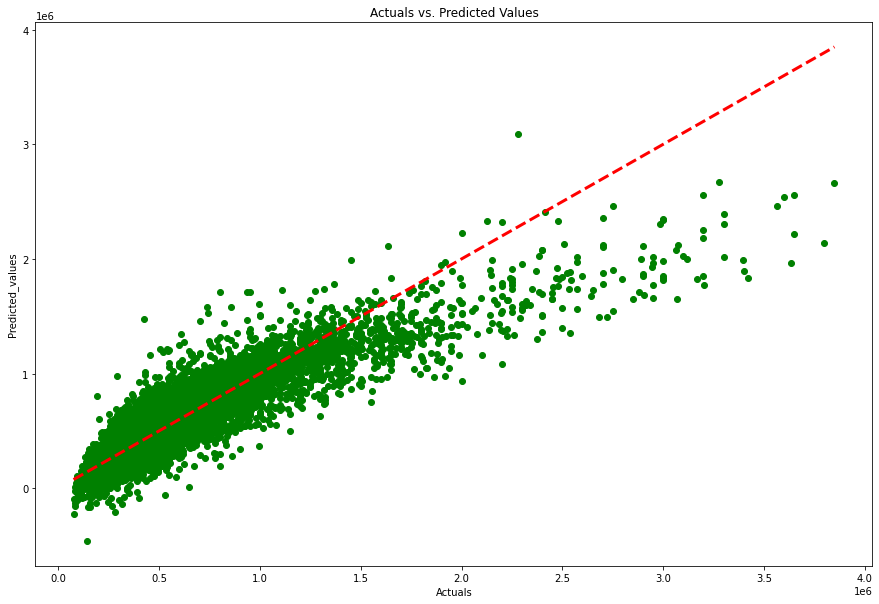

In [587]:
plt.figure(figsize = (15,10))
plt.scatter(y_train, y_pred, c = 'green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c = 'red', lw = 3)
plt.xlabel('Actuals')
plt.ylabel('Predicted_values')
plt.title('Actuals vs. Predicted Values');

# Boston Test -  Polynomial Regression

In [589]:
from sklearn import datasets

def load_extended_boston():
    boston = datasets.load_boston()
    X = boston.data
    
    X = MinMaxScaler().fit_transform(boston.data)
    X = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X)
    return X, boston.target

In [590]:
X, y = load_extended_boston()

In [591]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4)

In [592]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(379, 104)
(127, 104)
(379,)
(127,)


In [593]:
lr = LinearRegression().fit(X_train, y_train)

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.93
Test set score: 0.85


In [594]:
y_pred = lr.predict(X_train)

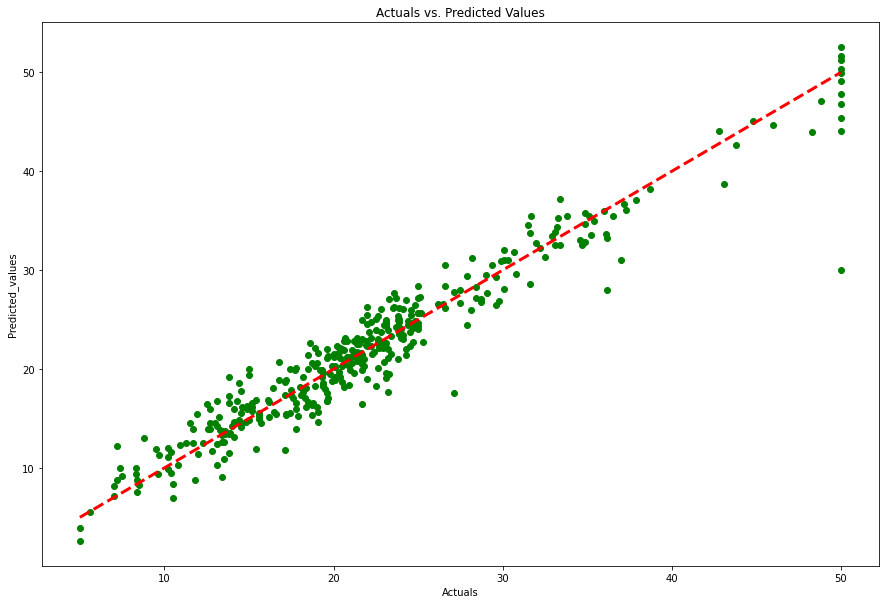

In [595]:
plt.figure(figsize = (15,10))
plt.scatter(y_train, y_pred, c = 'green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c = 'red', lw = 3)
plt.xlabel('Actuals')
plt.ylabel('Predicted_values')
plt.title('Actuals vs. Predicted Values');

# Polynomial KC Housing

In [797]:
y = df_split['price'] 
X = df_split.drop(['price'], axis = 1)

In [798]:
scale = StandardScaler()
X = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [799]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16200, 15)
(5401, 15)
(16200,)
(5401,)


In [800]:
# create the poly features to second degree. 

pr = PolynomialFeatures(2, include_bias = False)
X_train_poly = pr.fit_transform(X_train)
X_test_poly = pr.fit_transform(X_test)

# print(pr.get_feature_names())

print(X_train_poly.shape)

(16200, 135)


In [801]:
# fit the model to polynomial features
# There are now 136 columns in X_train_poly, that is an additional 121 interaction terms with 16200 records. 

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

# create predictions on fitted model. 
y_test_predict = lr.predict(X_test_poly)
print(y_test_predict.shape)

(5401,)


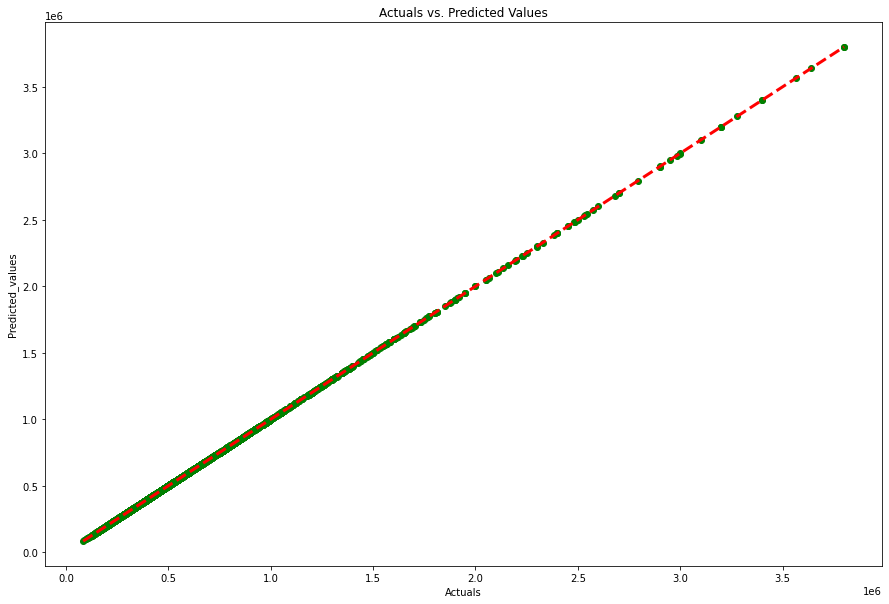

In [802]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, y_test_predict, c = 'green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c = 'red', lw = 3)
plt.xlabel('Actuals')
plt.ylabel('Predicted_values')
plt.title('Actuals vs. Predicted Values');

In [803]:
print("Training set score: {:.2f}".format(lr.score(X_train_poly, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_poly, y_test)))

Training set score: 1.00
Test set score: 1.00


#  3% Subset of KC Housing with Polynomial

In [808]:
df_split.shape

(21601, 16)

In [809]:
df_sub = df_split.sample(frac = .03, random_state = 2)

In [810]:
df_sub

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_total,price_per_sqft
12184,429000.0,3,2.50,2420,49928,2.0,0,0,3,8,1860,560,1985,0,54768,7.833041
18260,493000.0,6,1.75,2120,3801,1.5,0,0,4,7,1220,900,1925,0,8041,61.310782
19598,400000.0,3,1.00,1100,5100,2.0,0,0,4,7,1100,0,1900,0,7300,54.794521
16439,269900.0,5,1.75,1750,8325,1.0,0,0,5,7,1750,0,1966,0,11825,22.824524
11620,2795000.0,5,3.25,4590,12793,2.0,0,1,5,11,3590,1000,1928,0,21973,127.201566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,227000.0,3,1.75,1680,7455,1.0,0,0,4,8,1680,0,1968,0,10815,20.989367
12962,388500.0,3,2.25,1350,944,2.0,0,0,3,8,1050,300,2007,0,3644,106.613611
911,615000.0,4,2.25,2500,10062,1.0,0,0,3,8,1600,900,1975,0,15062,40.831231
5773,810000.0,4,2.50,3280,25211,2.0,0,1,3,11,3280,0,1985,0,31771,25.494948


In [811]:
y = df_sub['price'] 
X = df_sub.drop(['price'], axis = 1)

In [812]:
scale = StandardScaler()
X = scale.fit_transform(X)
# X = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [813]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(486, 15)
(162, 15)
(486,)
(162,)


In [814]:
pr = PolynomialFeatures(2, include_bias = False)
X_train_poly = pr.fit_transform(X_train)
X_test_poly = pr.fit_transform(X_test)

# print(pr.get_feature_names())

print(X_train_poly.shape)

(486, 135)


In [815]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

# create predictions on fitted model. 
y_test_predict = lr.predict(X_test_poly)
print(y_test_predict.shape)

(162,)


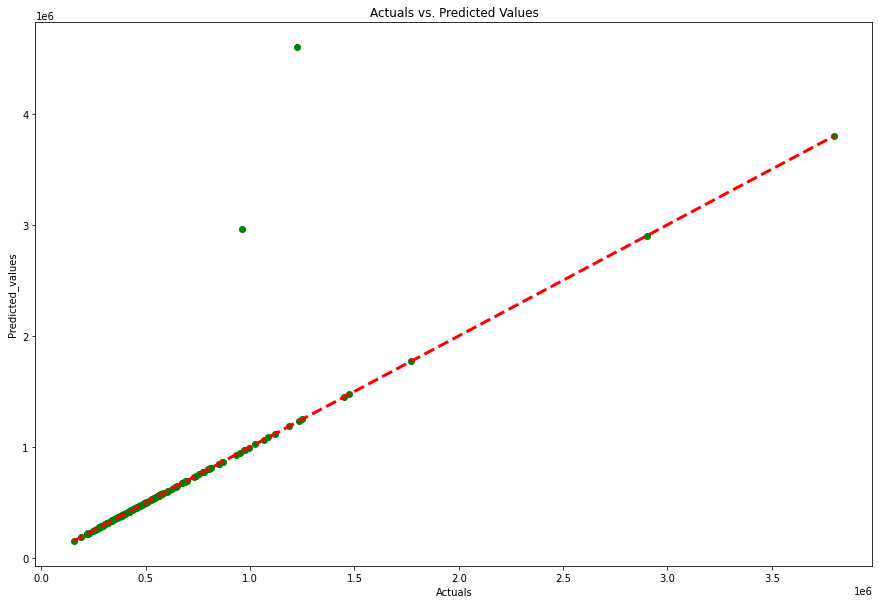

In [816]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, y_test_predict, c = 'green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c = 'red', lw = 3)
plt.xlabel('Actuals')
plt.ylabel('Predicted_values')
plt.title('Actuals vs. Predicted Values');

In [817]:
print("Training set score: {:.2f}".format(lr.score(X_train_poly, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_poly, y_test)))

Training set score: 1.00
Test set score: 0.45


In [818]:
cv_test = cross_val_score(lr, X_test_poly, y_test)
cv_test

array([0.78878695, 1.        , 0.34185964, 0.6730723 , 0.81858848])

# Conclusion 

In [804]:
# The model has overfitted the polynomial regression due to the combination of 16200 records, and 135 interaction terms.
# The polynomial regression technique is not consistent in producing results. 